---
title: Domains
---

In [59]:
import autoroot
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
import finitediffx as fdx
from jaxtyping import Array, Float
# from jaxsw._src.domain.base import Domain
from jaxsw._src.domain.base_v2 import Domain, init_domain_1d
import math
# from jaxsw._src.fields.base import Field
import jax.random as jrandom
from jaxsw import Field, FDField, SpectralField
from jaxsw._src.operators.functional import finitediff as F_fd
from jaxsw._src.operators.functional import spectral as F_spectral
import seaborn as sns

jax.config.update("jax_enable_x64", True)
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example 1: 1D Curve

$$
u(x) = \sin(2x) + \frac{1}{2}\cos(5x)
$$

In [60]:
f = lambda x: jnp.sin(2*x) + 0.5*jnp.cos(5*x)
df = jax.grad(f)
d2f = jax.grad(df)

In [61]:

Nx = 32
Lx = 2*math.pi
dx = Lx / Nx

# initialize domains
domain = Domain(xmin=0, xmax=Lx-dx, dx=dx, Lx=Lx, Nx=Nx)
domain_plot = Domain(xmin=0, xmax=Lx-dx, dx=0.1 * Lx / 10*Nx, Lx=Lx, Nx=10*Nx)

# initialize fields
u: Field = Field(values=f(domain.coords.squeeze()), domain=domain)
u_plot: Field = Field(values=f(domain_plot.coords.squeeze()), domain=domain_plot)

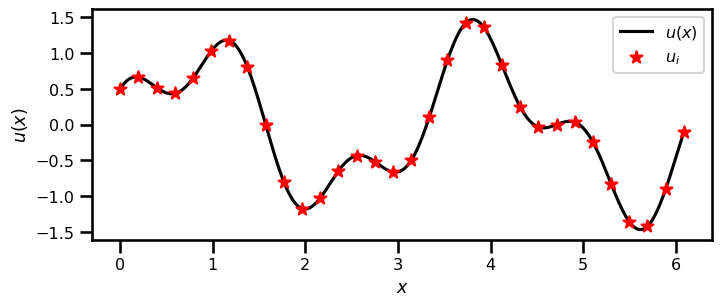

In [62]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(u_plot.domain.coords, u_plot[:], linestyle="-", color="black", label=f"$u(x)$")
ax.scatter(u.domain.coords, u[:], color="r", marker="*", label=f"$u_i$", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$u(x)$")
plt.legend()
plt.show()

### 1st Derivative

In [63]:
df = lambda x: (2.0 * jnp.cos(2.0 * x) - 2.5 * jnp.sin(5.0 * x)).squeeze()

In [64]:
dudx_plot = jax.vmap(df)(u_plot.domain.coords.squeeze())
dudx_analytical = jax.vmap(df)(u.domain.coords)

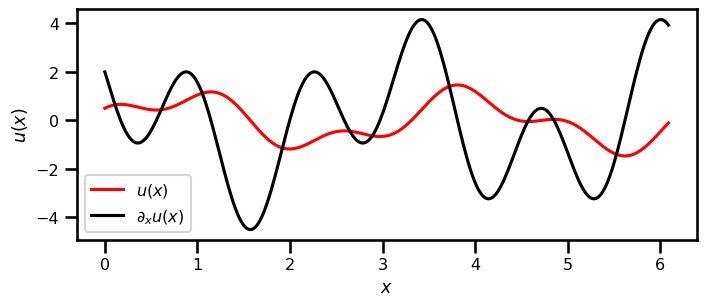

In [65]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(u_plot.domain.coords, u_plot[:], linestyle="-", color="red", label=f"$u(x)$")
ax.plot(u_plot.domain.coords, dudx_plot, linestyle="-", color="black", label=f"$\partial_x u(x)$")
ax.set(xlabel=r"$x$", ylabel=r"$u(x)$")
plt.legend()
plt.show()

## Pseudospectral Method

We need to create the vectors

$$
k = 
\left[ 
0, 1, 2, 3, \ldots, \frac{N_x}{2}, \frac{N_x}{2} + 1,
-\frac{N_x}{2}, -\frac{N_x}{2} + 2, \ldots, -3,  -2, -1
\right]
$$

In [68]:
Nx = u.domain.Nx[0]
Lx = u.domain.Lx[0]

k1 = jnp.arange(0, Nx/2)
k2 = jnp.arange(-Nx/2, 0)
k = (2.0 * jnp.pi / Lx ) * jnp.concatenate([k1, k2], axis=0)

k.shape

(32,)

We do the forward FFT transformation.
We divide by the scaler value.

In [69]:
# Forward FFT transform
fh = jnp.fft.fft(u[:])/Nx

We now do the multiplicative difference operator

In [70]:
# difference operator
dfh_dx = 1j * k * fh

We do the inverse FFT transformation

In [71]:
# inverse FFT transform
du_dx = jnp.fft.ifft(dfh_dx)

We remove the complex values and we rescale


In [72]:
# remove excess
dudx_sp = jnp.real( du_dx * Nx)

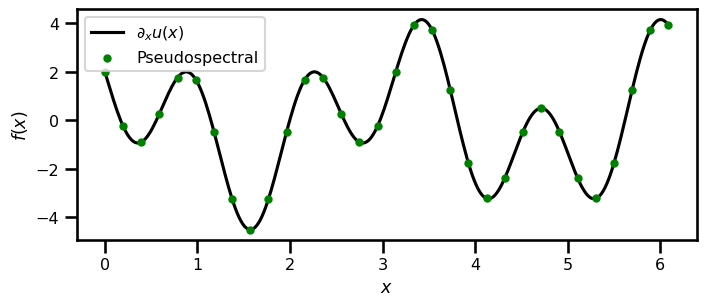

In [73]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(u_plot.domain.coords, dudx_plot, linestyle="-", color="black", label=f"$\partial_x u(x)$")
ax.scatter(
    u.domain.coords, dudx_sp[:], color="green", marker=".", label=f"Pseudospectral", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
plt.legend()
plt.show()

### Custom Functions

In [74]:

# calculate frequencies
k_vec = F_spectral.calculate_fft_freq(Nx, Lx)

# forward transformation
Fu = F_spectral.fft_transform(u[:], axis=0, scale=Nx, inverse=False)

# difference operator
dFudx = F_spectral.spectral_difference(Fu, k_vec, axis=0, derivative=1)

# # inverse transformation
dudx_sp = F_spectral.fft_transform(dFudx, axis=0, scale=Nx, inverse=True)

dudx_sp = jnp.real(dudx_sp)

### Functional API

In [75]:


# calculate frequencies
k_vec = F_spectral.calculate_fft_freq(u.domain.Nx[0], u.domain.Lx[0])

# calculate the derivative
dudx_sp = F_spectral.difference(u=u[:], k_vec=k_vec, axis=0, derivative=1, real=True)


### Functional Field API

In [76]:
# initialize field
u_spectral = SpectralField(values=u[:], domain=u.domain)

# derivative
dudx_spectral = F_spectral.difference_field(u=u_spectral, axis=0, derivative=1, real=True)


In [77]:
dudx_spectral

SpectralField(
  values=f64[32],
  domain=Domain(
    xmin=(0,),
    xmax=(6.086835766330224,),
    dx=(0.19634954084936207,),
    Nx=(32,),
    Lx=(6.283185307179586,),
    ndim=1
  )
)

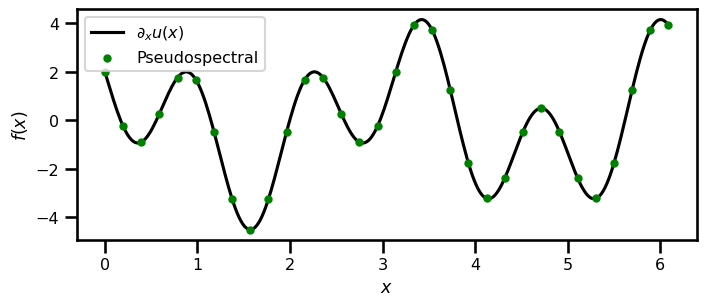

In [78]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(u_plot.domain.coords, dudx_plot, linestyle="-", color="black", label=f"$\partial_x u(x)$")
ax.scatter(
    dudx_spectral.domain.coords.squeeze(), dudx_spectral[:], color="green", marker=".", label=f"Pseudospectral", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
plt.legend()
plt.show()

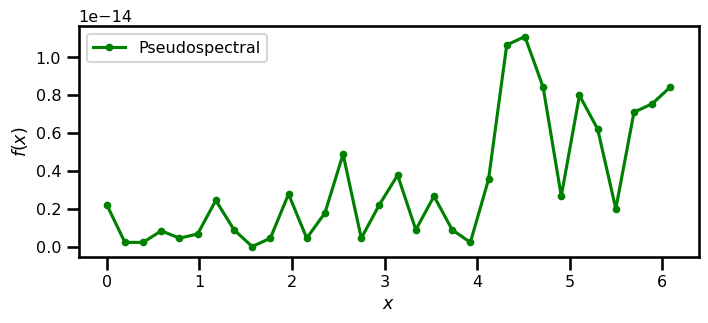

In [79]:
fig, ax = plt.subplots(figsize=(8,3))

ps_error = np.abs(dudx_spectral[:] - dudx_analytical[:])

ax.plot(u.domain.coords, ps_error, color="green", marker=".", label=f"Pseudospectral", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
plt.legend()
plt.show()

### 2nd Derivative

In [80]:
d2udx2_plot = jax.vmap(d2f)(u_plot.domain.coords.squeeze())
d2udx2_analytical = jax.vmap(d2f)(u.domain.coords.squeeze())

#### Pseudospectral

In [81]:
# initialize field
u_spectral = SpectralField(values=u[:], domain=u.domain)

# derivative
d2udx2_spectral = F_spectral.difference_field(u=u_spectral, axis=0, derivative=2, real=True)


#### Viz: Derivatives

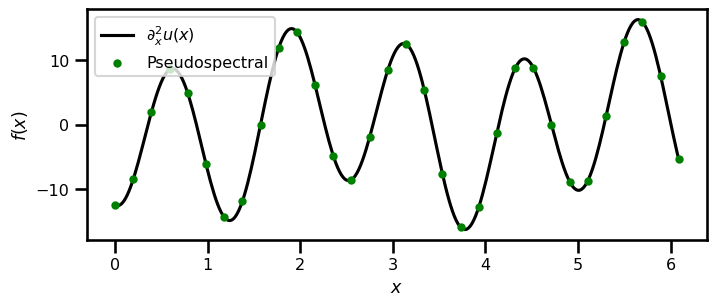

In [82]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(u_plot.domain.coords, d2udx2_plot, linestyle="-", color="black", label=f"$\partial^2_x u(x)$")
ax.scatter(
    d2udx2_spectral.domain.coords.squeeze(), d2udx2_spectral[:], color="green", marker=".", label=f"Pseudospectral", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
plt.legend()
plt.show()

#### Visualization: Numerical Error

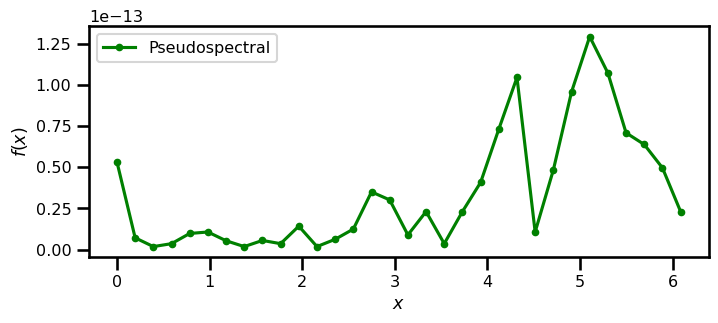

In [83]:
fig, ax = plt.subplots(figsize=(8,3))

ps_error = np.abs(d2udx2_spectral[:] - d2udx2_analytical[:])

ax.plot(u.domain.coords, ps_error, color="green", marker=".", label=f"Pseudospectral", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
plt.legend()
plt.show()

## Example 2: 2D Scalar Field

$$
u(x,y) = \cos \left(m_x \frac{2\pi}{L_x}x \right) \sin \left(m_y \frac{2\pi}{L_y}y \right)
$$

In [84]:
def f(x, y, Lx, Ly, mx, my):
    return jnp.cos(mx* 2 * jnp.pi * x / Lx) * jnp.sin(my * 2*jnp.pi*y / Ly)

# define gradient functions
df_dx = jax.grad(f, argnums=0)
df_dy = jax.grad(f, argnums=1)

In [85]:
mx, my = 3, 2
Nx, Ny = 64, 64
# Lx, Ly = 2.0*jnp.pi, 2.0*jnp.pi
Lx, Ly = 2*math.pi, 2*math.pi
dx, dy = Lx/Nx, Ly/Ny

# create individual domains
x_domain = Domain(xmin=0, xmax=Lx-dx, Lx=Lx, Nx=Nx, dx=dx)
y_domain = Domain(xmin=0, xmax=Ly-dx, Lx=Ly, Nx=Ny, dx=dy)

# create joint domain
xy_domain = x_domain * y_domain

In [86]:

kernel = lambda x,y: f(x,y,Lx,Ly,mx,my)
kernel_grad_x = lambda x,y: df_dx(x,y,Lx,Ly,mx,my)
kernel_grad_y = lambda x,y: df_dy(x,y,Lx,Ly,mx,my)

def gram_matrix(f, x, y):
    return jax.vmap(lambda x: jax.vmap(lambda y: f(x, y))(y))(x)

x_coords, y_coords = xy_domain.coords_axis

u_true = gram_matrix(kernel, x_coords, y_coords)
du_dx_true = gram_matrix(kernel_grad_x, x_coords, y_coords)
du_dy_true = gram_matrix(kernel_grad_y, x_coords, y_coords)

# create fields
u: Field = Field(values=u_true, domain=xy_domain)
dudx: Field = Field(values=du_dx_true, domain=xy_domain)
dudy: Field = Field(values=du_dy_true, domain=xy_domain)

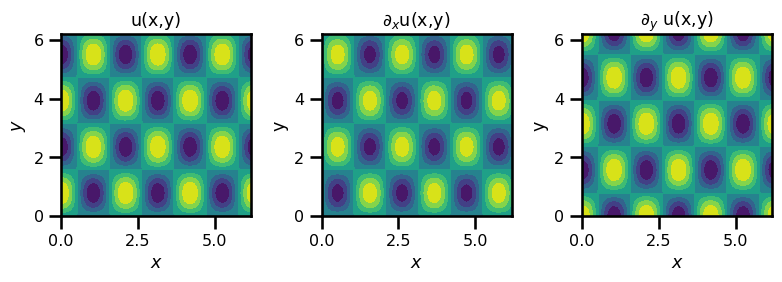

In [87]:
fig, ax = plt.subplots(ncols=3, figsize=(8,3))

X, Y = u.domain.grid_axis

ax[0].contourf(X, Y, u[:],)
ax[1].contourf(X, Y, dudx[:])
ax[2].contourf(X, Y, dudy[:])

ax[0].set(title="u(x,y)", xlabel="$x$", ylabel="$y$")
ax[1].set(title="$\partial_x $u(x,y)", xlabel="$x$", ylabel=r"y")
ax[2].set(title="$\partial_y$ u(x,y)", xlabel="$x$", ylabel="y")
plt.tight_layout()
plt.show()

#### Pseudospectral

In [88]:
# initialize field
u_spectral = SpectralField(values=u[:], domain=u.domain)

# derivative
dudx_spectral = F_spectral.difference_field(u=u_spectral, axis=0, derivative=1, real=True)
dudy_spectral = F_spectral.difference_field(u=u_spectral, axis=1, derivative=1, real=True)


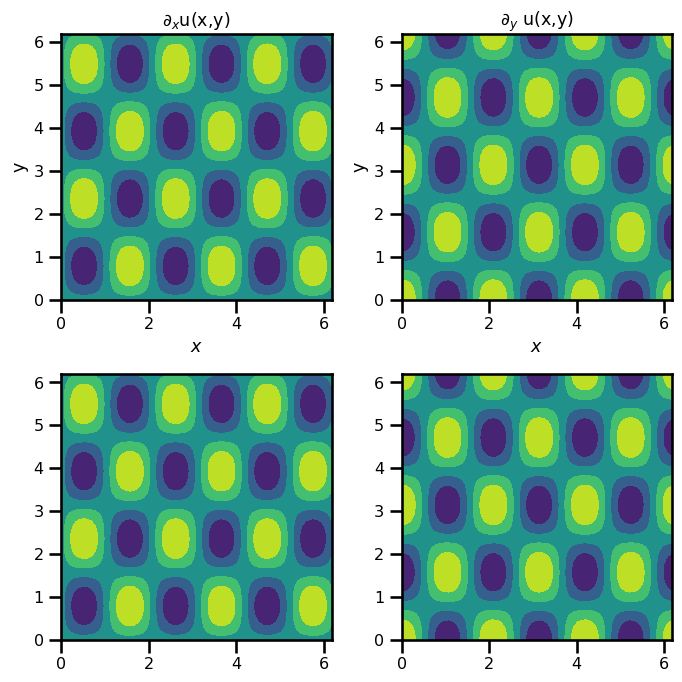

In [89]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(7,7))

x_levels = np.linspace(dudx[:].min(), dudx[:].max(), 6)
y_levels = np.linspace(dudy[:].min(), dudy[:].max(), 6)


ax[0,0].contourf(X, Y, dudx[:], levels=x_levels)
ax[0,1].contourf(X, Y, dudy[:], levels=y_levels)

X, Y = dudx_spectral.domain.grid_axis

ax[1,0].contourf(X, Y, dudx_spectral[:], levels=x_levels)
ax[1,1].contourf(X, Y, dudy_spectral[:], levels=y_levels)

ax[0,0].set(title="$\partial_x $u(x,y)", xlabel="$x$", ylabel=r"y")
ax[0,1].set(title="$\partial_y$ u(x,y)", xlabel="$x$", ylabel="y")
plt.tight_layout()
plt.show()

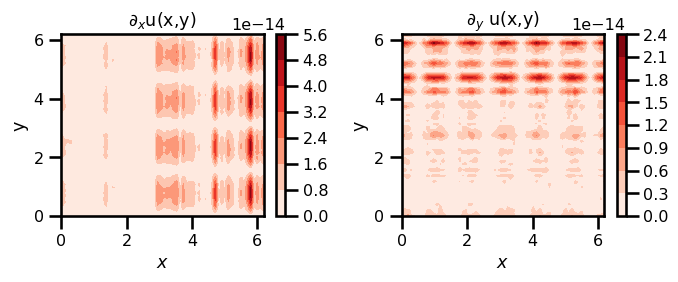

In [90]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(7,3))



ps_err_x = np.abs(dudx[:] - dudx_spectral[:])
ps_err_y = np.abs(dudy[:] - dudy_spectral[:])

pts=ax[0].contourf(X, Y, ps_err_x, cmap="Reds")
plt.colorbar(pts)
pts=ax[1].contourf(X, Y, ps_err_y, cmap="Reds")
plt.colorbar(pts)

ax[0].set(title="$\partial_x $u(x,y)", xlabel="$x$", ylabel=r"y")
ax[1].set(title="$\partial_y$ u(x,y)", xlabel="$x$", ylabel="y")
plt.tight_layout()
plt.show()

## Example: QG

$$
\partial_t q + u \partial_x q + v \partial_y q = \nu \Delta q
$$

where 
* $q=\Delta\psi$ - relative vorticity
* $u=-\partial_u\psi$ - zonal velocity
* $v=\partial_x\psi$ - meridonal velocity

In [91]:
Nx, Ny = 64, 64
Lx, Ly = 2.0*math.pi, 2.0*math.pi
dx, dy = Lx/Nx, Ly/Ny

x_domain = Domain(xmin=0, xmax=Lx-dx, dx=dx, Nx=Nx, Lx=Lx)
y_domain = Domain(xmin=0, xmax=Ly-dy, dx=dy, Nx=Ny, Lx=Ly)

xy_domain = x_domain * y_domain

In [92]:
# construct parameters
key = jrandom.PRNGKey(123)
u0: Array = jrandom.normal(key=key, shape=xy_domain.Nx)
u: Field = SpectralField(values=u0, domain=xy_domain) 

In [93]:
u.k_vec[0].shape, u.k_vec[1].shape

((64,), (64,))

In [96]:
import einops
import functools
import typing as tp


In [97]:
def elliptical_operator(k_vec: tp.Iterable[Array], order: int=2) -> Array:

    shape = tuple(map(lambda x: len(x), k_vec))

    # expand each of the dimensions
    ks = [jnp.expand_dims(array, axis=i) for i, array in enumerate(k_vec)]


    # sum each of dimensions
    ksq = functools.reduce(lambda x,y: x**order + y**order, ks)

    ksq = ksq.T
    
    return ksq

def spectral_elliptical_inversion(u: SpectralField):

    # calculate scalar quantity
    ksq = elliptical_operator(u.k_vec)

    uh_values = jnp.fft.fftn(u[:]) / sum(u.domain.Nx)

    # do inversion
    invksq = 1.0 / ksq
    invksq = invksq.at[0,0].set(1.0)

    uh_values = - invksq * uh_values

    u_values = sum(u.domain.Nx) * jnp.fft.ifftn(uh_values)
    
    return SpectralField(values=u_values, domain=u.domain)

In [98]:
k = u.k_vec[0]
l = u.k_vec[1]

K = np.zeros(shape=u.domain.Nx)
L = np.zeros(shape=u.domain.Nx)
for i in range(len(k)):
    for j in range(len(l)):
        K[i,j] = k[i]
        L[i,j] = l[j]
        

In [99]:
ksq = K**2 + L**2
invksq = 1.0 / ksq
invksq[0,0] = 1.0

print(invksq.min(), invksq.max())

0.00048828125 1.0


/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_66248/1165394992.py:2: RuntimeWarning: divide by zero encountered in divide
  invksq = 1.0 / ksq


In [100]:
invksq.shape

(64, 64)

In [101]:
# potential vorticity
rng = np.random.RandomState(42)
q0 = rng.randn(*xy_domain.Nx)
qh0 = np.fft.fftn(q0)
qh0 = np.where(ksq > 10**2, 0.0, qh0)
qh0 = np.where(ksq < 3**2, 0.0, qh0)
q0 = np.real(np.fft.ifftn(qh0))

# stream function
psih0 = - invksq * qh0
psi0 = np.real(np.fft.ifftn(psih0))

# velocities
u0 = np.real(np.fft.ifftn(-1j * L * psih0))
v0 = np.real(np.fft.ifftn(1j * K * psih0))

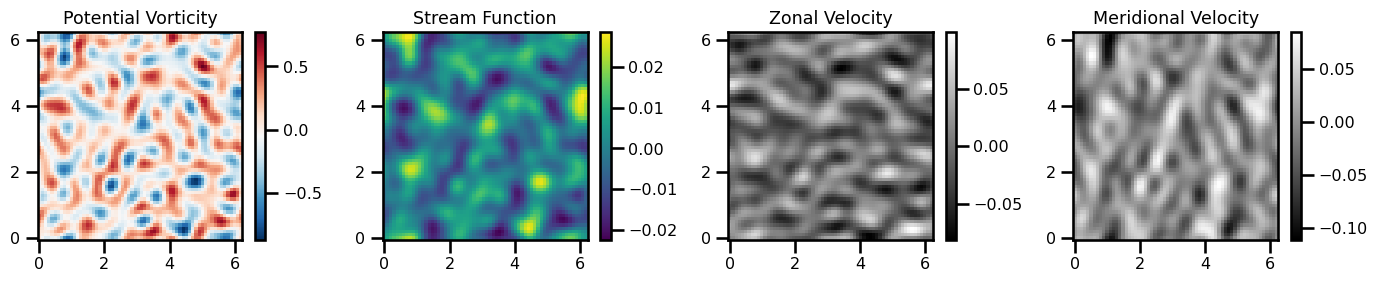

In [102]:
fig, ax = plt.subplots(ncols=4, figsize=(14,3))

X, Y = xy_domain.grid_axis

pts = ax[0].pcolormesh(X, Y, q0, cmap="RdBu_r")
ax[0].set(title="Potential Vorticity")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, psi0)
ax[1].set(title="Stream Function")
plt.colorbar(pts)

pts = ax[2].pcolormesh(X, Y, u0, cmap="gray")
ax[2].set(title="Zonal Velocity")
plt.colorbar(pts)

pts = ax[3].pcolormesh(X, Y, v0, cmap="gray")
ax[3].set(title="Meridional Velocity")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [103]:
ksq_ = F_spectral.elliptical_operator_2D(u.k_vec)
np.testing.assert_array_almost_equal(ksq_, ksq)

In [104]:
# potential vorticity
rng = np.random.RandomState(42)
q0 = rng.randn(*xy_domain.Nx)
q0: Field = SpectralField(values=q0, domain=xy_domain) 
k_vec = q0.k_vec
q0 = q0[:]
qh0 = np.fft.fftn(q0)
ksq = F_spectral.elliptical_operator_2D(k_vec)
qh0 = np.where(ksq > 10**2, 0.0, qh0)
qh0 = np.where(ksq < 3**2, 0.0, qh0)
q0 = np.real(np.fft.ifftn(qh0))

q0: Field = SpectralField(values=q0, domain=xy_domain) 

# calculate psi
psi0: SpectralField = F_spectral.elliptical_inversion_2D(q0)

# calculate velocities
u0: SpectralField = - F_spectral.difference_field(psi0, axis=1, derivative=1)
v0: SpectralField = F_spectral.difference_field(psi0, axis=0, derivative=1)

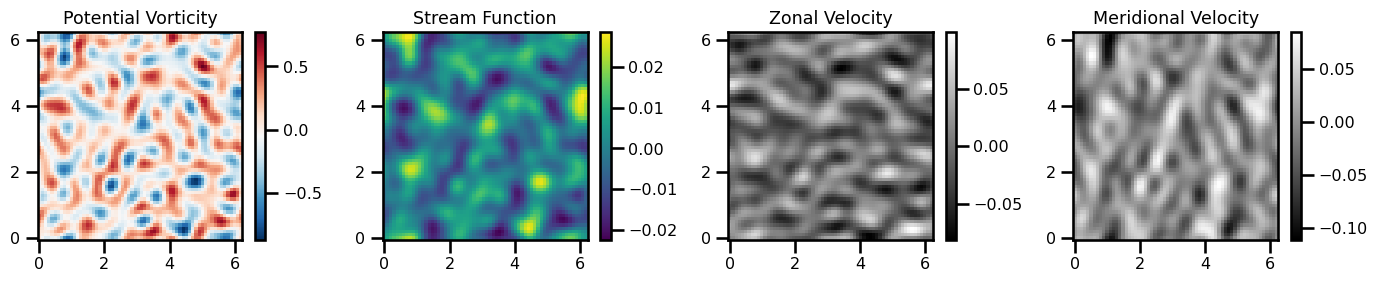

In [105]:
fig, ax = plt.subplots(ncols=4, figsize=(14,3))

X, Y = xy_domain.grid_axis

pts = ax[0].pcolormesh(X, Y, q0[:], cmap="RdBu_r")
ax[0].set(title="Potential Vorticity")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, psi0[:])
ax[1].set(title="Stream Function")
plt.colorbar(pts)

pts = ax[2].pcolormesh(X, Y, u0[:], cmap="gray")
ax[2].set(title="Zonal Velocity")
plt.colorbar(pts)

pts = ax[3].pcolormesh(X, Y, v0[:], cmap="gray")
ax[3].set(title="Meridional Velocity")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

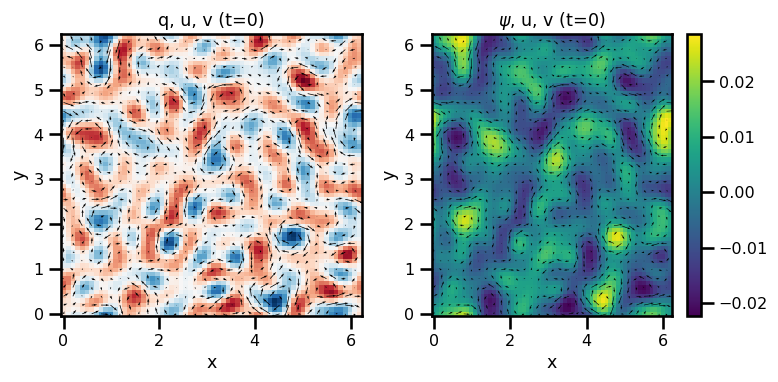

In [106]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

nc = int(Nx/32)

X, Y = q0.domain.grid_axis

pts = ax[0].pcolormesh(X, Y, q0[:], cmap="RdBu_r")
ax[0].quiver(X[::nc,::nc], Y[::nc,::nc], u0[::nc,::nc], v0[::nc,::nc])
ax[0].set(xlabel="x", ylabel="y", title="q, u, v (t=0)")

pts = ax[1].pcolormesh(X, Y, psi0[:], cmap="viridis")
ax[1].quiver(X[::nc,::nc], Y[::nc,::nc], u0[::nc,::nc], v0[::nc,::nc])
ax[1].set(xlabel="x", ylabel="y", title="$\psi$, u, v (t=0)")


plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [107]:
def laplacian(u: Field) -> Field:
    d2udx2 = F_spectral.difference_field(u, axis=0, derivative=2)
    d2udy2 = F_spectral.difference_field(u, axis=1, derivative=2)
    return d2udx2 + d2udy2

In [108]:
from jaxsw._src.operators.constant import Constant

In [109]:
from jaxsw._src.utils.spectral import calculate_fft_freq
def init_q0(domain: Domain, seed: int=42):

    # initialize random state
    rng = np.random.RandomState(42)
    
    # initialize q to be noise
    q0 = rng.randn(*domain.Nx)

    # FFT transform
    qh0 = np.fft.fftn(q0)

    # calculate spectral frequencies
    k_vec = [calculate_fft_freq(Nx=Nx, Lx=Lx) for Nx, Lx in zip(domain.Nx, domain.Lx)]

    # calculate elliptical operator
    ksq = F_spectral.elliptical_operator_2D(k_vec)

    # remove excess frequencies
    qh0 = np.where(ksq > 10**2, 0.0, qh0)
    qh0 = np.where(ksq < 3**2, 0.0, qh0)

    # return real values
    q0 = np.real(np.fft.ifftn(qh0))
    
    return SpectralField(values=jnp.asarray(q0), domain=domain)

#### Equation of Motion

In [112]:
nu=3.0e-04

def equation_of_motion(q: Field) -> Field:

    # calculate streamfunction
    psi: SpectralField = F_spectral.elliptical_inversion_2D(q)

    # calculate velocities - u | v
    u: SpectralField = - F_spectral.difference_field(psi, axis=1, derivative=1)
    v: SpectralField = F_spectral.difference_field(psi, axis=0, derivative=1)
    # calculate gradient pv's - ∂ζ/∂x | ∂ζ/∂y
    dqdx: SpectralField = F_spectral.difference_field(q, axis=0, derivative=1)
    dqdy: SpectralField = F_spectral.difference_field(q, axis=1, derivative=1)

    # calculate diffusion
    diffusion = Constant(nu) * laplacian(q)
    # hyperviscosity
    # diffusion = Constant(nu) * laplacian(laplacian(q))
    
    # calculate rhs
    rhs = - (u * dqdx + v * dqdy) - diffusion

    return rhs

In [113]:
q0: SpectralField = init_q0(xy_domain)
rhs = equation_of_motion(q0)

In [114]:
q0.domain.Nx, rhs.domain.Nx

((64, 64), (64, 64))

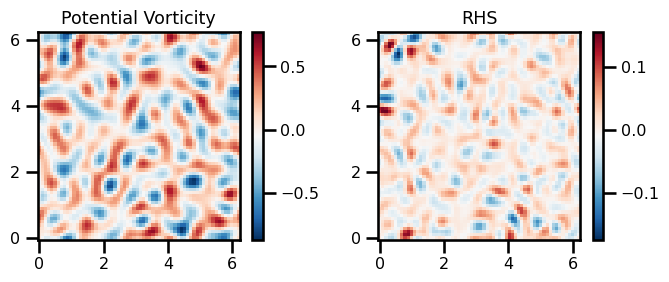

In [115]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))

X, Y = q0.domain.grid_axis

pts = ax[0].pcolormesh(X, Y, q0[:], cmap="RdBu_r")
ax[0].set(title="Potential Vorticity")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, rhs[:], cmap="RdBu_r")
ax[1].set(title="RHS")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

### Time Stepping

In [129]:
nu=3.0e-04

dt = 0.025
t1 = 1_000
num_steps = int(t1/dt)

ts = jnp.arange(0, t1, dt)

In [130]:
import diffrax as dfx

In [131]:
# Euler, Constant StepSize
solver = dfx.Euler()
stepsize_controller = dfx.ConstantStepSize()

In [132]:
t0, t1 = 0.0, 10.0 #1_000.0
t_save = np.linspace(t0, t1, 100)
saveat = dfx.SaveAt(ts=t_save)

In [133]:
class State(tp.NamedTuple):
    q: Field

In [134]:
state_init = State(q0)


def vector_field(t, y, args):
    q = y.q
    rhs = equation_of_motion(q)
    return State(rhs)

In [135]:
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=None,
    stepsize_controller=stepsize_controller,
)

In [136]:
sol.ys

State(q=SpectralField(
  values=f64[100,64,64],
  domain=Domain(
    xmin=(0, 0),
    xmax=(6.1850105367549055, 6.1850105367549055),
    dx=(0.09817477042468103, 0.09817477042468103),
    Nx=(64, 64),
    Lx=(6.283185307179586, 6.283185307179586),
    ndim=2
  )
))

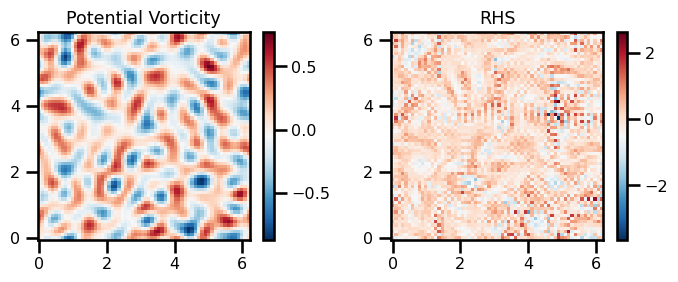

In [138]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))

X, Y = q0.domain.grid_axis

pts = ax[0].pcolormesh(X, Y, q0[:], cmap="RdBu_r")
ax[0].set(title="Potential Vorticity")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, sol.ys.q[-1][:], cmap="RdBu_r")
ax[1].set(title="RHS")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

## Trial II

In [107]:
from jaxsw._src.utils.spectral import calculate_fft_freq
def init_q0(domain: Domain, seed: int=42):

    # initialize random state
    rng = np.random.RandomState(42)
    
    # initialize q to be noise
    q0 = rng.randn(*domain.Nx)

    # FFT transform
    qh0 = np.fft.fftn(q0)

    # calculate spectral frequencies
    k_vec = [calculate_fft_freq(Nx=Nx, Lx=Lx) for Nx, Lx in zip(domain.Nx, domain.Lx)]

    # calculate elliptical operator
    ksq = F_spectral.elliptical_operator_2D(k_vec)

    # remove excess frequencies
    qh0 = np.where(ksq > 10**2, 0.0, qh0)
    qh0 = np.where(ksq < 3**2, 0.0, qh0)

    # return real values
    q0 = np.real(np.fft.ifftn(qh0))
    
    return SpectralField(values=jnp.asarray(qh0), domain=domain)

In [121]:
def equation_of_motion(q: Field) -> Field:

    print(q)

    # inverse FFT
    q_values = jnp.fft.ifftn(q.values)
    q = SpectralField(q_values, q.domain)
    
    # calculate streamfunction
    psi: SpectralField = F_spectral.elliptical_inversion_2D(q)

    # calculate velocities - u | v
    u: SpectralField = - F_spectral.difference_field(psi, axis=1, derivative=1)
    v: SpectralField = F_spectral.difference_field(psi, axis=0, derivative=1)
    # calculate gradient pv's - ∂ζ/∂x | ∂ζ/∂y
    dqdx: SpectralField = F_spectral.difference_field(q, axis=0, derivative=1)
    dqdy: SpectralField = F_spectral.difference_field(q, axis=1, derivative=1)

    # calculate diffusion
    diffusion = Constant(nu) * laplacian(q)
    
    # calculate rhs
    rhs = - (u * dqdx + v * dqdy) - diffusion

    # FFT transformation
    rhs_values = jnp.fft.fftn(rhs.values)
    rhs = SpectralField(rhs_values, q.domain)

    print(rhs)

    return rhs

#### Equation of Motion

In [122]:
q0: SpectralField = init_q0(xy_domain)
rhs = equation_of_motion(q0)

SpectralField(
  values=c128[64,64],
  domain=Domain(
    xmin=(0, 0),
    xmax=(6.283185307179586, 6.283185307179586),
    dx=(0.09817477042468103, 0.09817477042468103),
    Nx=(64, 64),
    Lx=(6.283185307179586, 6.283185307179586),
    ndim=2
  )
)
SpectralField(
  values=c128[64,64],
  domain=Domain(
    xmin=(0, 0),
    xmax=(6.283185307179586, 6.283185307179586),
    dx=(0.09817477042468103, 0.09817477042468103),
    Nx=(64, 64),
    Lx=(6.283185307179586, 6.283185307179586),
    ndim=2
  )
)


In [110]:
q0.domain.Nx, rhs.domain.Nx

((64, 64), (64, 64))

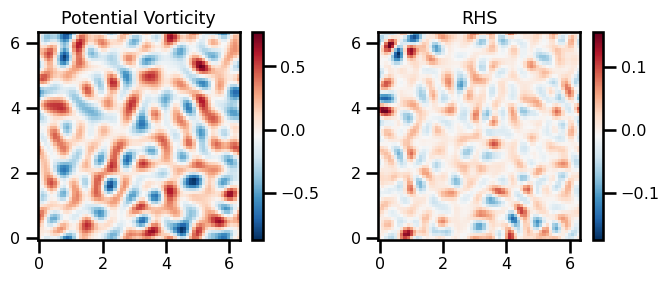

In [112]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))

X, Y = q0.domain.grid_axis

pts = ax[0].pcolormesh(X, Y, np.real(np.fft.ifftn(q0[:])), cmap="RdBu_r")
ax[0].set(title="Potential Vorticity")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, np.real(np.fft.ifftn(rhs[:])), cmap="RdBu_r")
ax[1].set(title="RHS")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

### Time Stepping

In [113]:
nu=3.0e-04

dt = 0.025
t1 = 1_000
num_steps = int(t1/dt)

ts = jnp.arange(0, t1, dt)

In [114]:
import diffrax as dfx

In [115]:
# Euler, Constant StepSize
solver = dfx.Tsit5()
stepsize_controller = dfx.ConstantStepSize()

In [116]:
t0, t1 = 0.0, 100.0 #1_000.0
t_save = np.linspace(t0, t1, 100)
saveat = dfx.SaveAt(ts=t_save)

In [117]:
class State(tp.NamedTuple):
    q: Field

In [118]:
state_init = State(q0)


def vector_field(t, y, args):
    q = y.q
    rhs = equation_of_motion(q)
    return State(rhs)

In [119]:
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=None,
    stepsize_controller=stepsize_controller,
)

ValueError: When doing `buffer.at[i].set(value)`, then `value` must have a dtype that can be promoted to the same dtype as `buffer`.

In [101]:
sol.ys

State(q=SpectralField(
  values=f64[100,64,64],
  domain=Domain(
    xmin=(0, 0),
    xmax=(6.283185307179586, 6.283185307179586),
    dx=(0.09817477042468103, 0.09817477042468103),
    Nx=(64, 64),
    Lx=(6.283185307179586, 6.283185307179586),
    ndim=2
  )
))

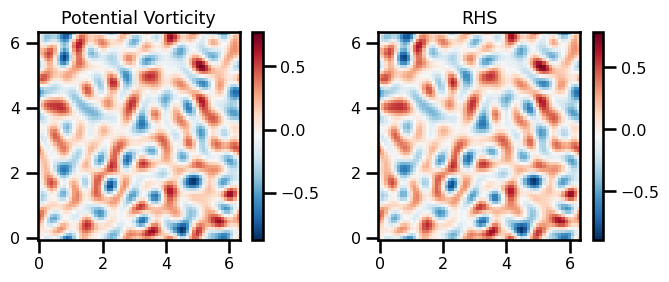

In [105]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))

X, Y = q0.domain.grid_axis

pts = ax[0].pcolormesh(X, Y, q0[:], cmap="RdBu_r")
ax[0].set(title="Potential Vorticity")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, sol.ys.q[1][:], cmap="RdBu_r")
ax[1].set(title="RHS")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [55]:
from tqdm.autonotebook import tqdm

q: SpectralField = init_q0(xy_domain)

fn = jax.jit(equation_of_motion)

for t in tqdm(ts[:350]):

    rhs = fn(q)

    q = q + Constant(dt) * rhs

  0%|          | 0/350 [00:00<?, ?it/s]

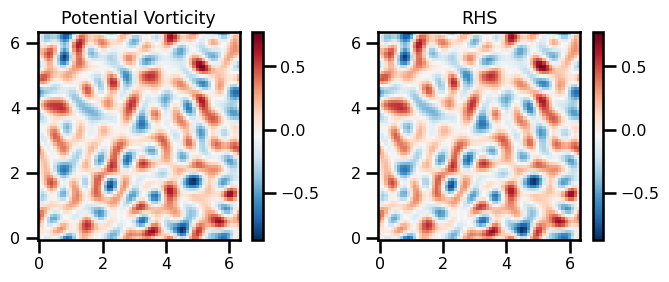

In [82]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))

X, Y = q0.domain.grid_axis

pts = ax[0].pcolormesh(X, Y, q0[:], cmap="RdBu_r")
ax[0].set(title="Potential Vorticity")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, sol.ys.q[-1][:], cmap="RdBu_r")
ax[1].set(title="RHS")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [129]:
q.values

Array([[-2.59740223e+11, -5.45891660e+11, -1.17098501e+13, ...,
         2.62541095e+10,  6.04272780e+11,  2.30330425e+12],
       [-7.66357222e+10,  5.55012416e+12,  5.29430291e+11, ...,
        -2.08857741e+09, -1.59000607e+11, -9.60660572e+10],
       [-1.78646442e+11,  6.29554136e+11,  5.59866564e+09, ...,
        -3.11968450e+08, -2.38665652e+09,  1.82370873e+10],
       ...,
       [ 2.88669004e+10,  7.01948414e+10,  4.13577213e+08, ...,
         1.28344265e+06, -2.53771833e+08, -7.55344205e+07],
       [-7.72661619e+11, -8.25053728e+11, -6.32000769e+09, ...,
        -2.81922236e+08,  9.42662401e+08, -1.97041577e+10],
       [ 8.63028165e+10,  3.78337984e+12, -1.22252482e+12, ...,
         1.06404236e+10,  1.11004733e+11,  9.79311516e+11]],      dtype=float64)

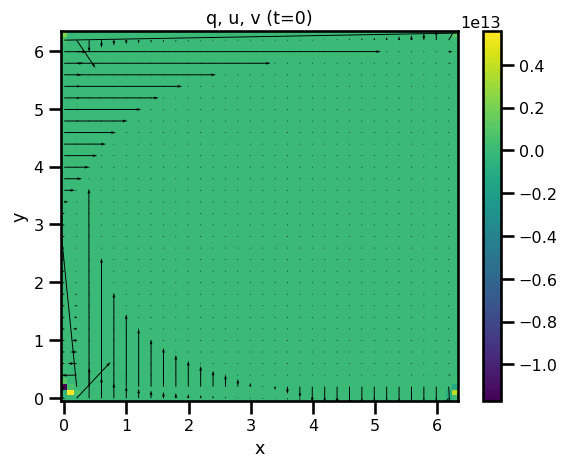

In [130]:
fig, ax = plt.subplots()

# calculate relevant quantities
psi: SpectralField = spectral_elliptical_inversion(q)
u: SpectralField = - F_spectral.difference_field(psi, axis=1, derivative=1)
v: SpectralField = F_spectral.difference_field(psi, axis=0, derivative=1)

nc = int(Nx/32)

X, Y = xy_domain.grid_axis

pts = ax.pcolormesh(X, Y, q[:])

ax.quiver(X[::nc,::nc], Y[::nc,::nc], u[::nc,::nc], v[::nc,::nc])

ax.set(xlabel="x", ylabel="y", title="q, u, v (t=0)")
plt.colorbar(pts)
plt.show()